Create new metadata file for mortality analysis. Include both CTs from round1 & round2 of analysis. Make sure to remove corrupted round2 CTs from metadata.

How to model patient who received second transplant and then died?

In [1]:
import pandas as pd
import re
import os

## Process round 2 of CTs

In [2]:
data = pd.read_csv(f'{path}/round2_overview_w_round1_maj_vote.csv', index_col=0)

In [3]:
data.columns

Index(['filename', 'date_of_CT', 'CLAD', 'ACR', 'AMR', 'Pneumonia', 'CLAD_pos',
       'CLAD_neg', 'CLAD_conflict', 'ACR_pos', 'ACR_neg', 'ACR_conflict',
       'AMR_pos', 'AMR_neg', 'AMR_conflict', 'Pneumonia_pos', 'Pneumonia_neg',
       'Pneumonia_conflict', 'Patient', 'Sex', 'Race', 'ct_number', 'project',
       'Mortality', 'transplant_status', 'date_of_death', 'tx_date',
       'tx_date_2', 'tx_date_3', 'analysis_round'],
      dtype='object')

In [4]:
data = data[['filename', 'date_of_CT', 'Patient', 'Sex', 'Race',
            'project', 'Mortality', 'date_of_death', 'tx_date',
            'tx_date_2', 'tx_date_3', 'analysis_round']]

### Fresh "date_of_death" pulldown - March 4, 2025

In [6]:
data = data.drop(columns=['date_of_death', 'Mortality'])

In [7]:
mortality = pd.read_csv(f'{path}/date_of_death_20250304.csv', index_col=0)

### Merge

In [8]:
data = data.merge(mortality, on="Patient", how="left")

### Fill in missing dates

In [9]:
data['date_of_death'] = data['date_of_death'].fillna('None')

In [10]:
data = data.replace({pd.NA: None, pd.NaT: None, float('nan'): None})

In [11]:
data['date_of_death'] = data['date_of_death'].replace('None', None)
data['Mortality'] = data['date_of_death'].apply(lambda x: 'Alive' if x is None else 'Dead')

### Create columns: 6m_mortality, 12m_mortality, 36m_mortality

In [13]:
data['date_of_CT'] = pd.to_datetime(data['date_of_CT'].astype(str).str.strip(), format='mixed', errors='coerce')
data['date_of_death'] = pd.to_datetime(data['date_of_death'].astype(str).str.strip(), format='mixed', errors='coerce')

In [14]:
data['days_until_death'] = (data['date_of_death'] - data['date_of_CT']).dt.days

In [15]:
data['mortality_6m'] = (data['days_until_death'] <= 180).astype(int)
data['mortality_12m'] = (data['days_until_death'] <= 365).astype(int)
data['mortality_36m'] = (data['days_until_death'] <= 1095).astype(int)

In [16]:
data[['mortality_6m', 'mortality_12m', 'mortality_36m']] = data[['mortality_6m', 'mortality_12m', 'mortality_36m']].fillna(0)

### Remove rows corresponding to corrupted files
Corrupted files were identified during preprocessing. See github issue [here](https://github.com/NUPulmonary/CLAD_serial_CT/issues/1#issuecomment-2695279360).

In [17]:
data = data[~data.filename.isin(
        ['LT048_1', 'LT096_5', 'LT184_8', 'LT204_5', 'LT215_8', 'LT228_7',
        'LT010_3', 'LT121_6', 'LT087_2', 'LT044_1', 'LT235_2', 'LT152_4', 'LT182_15']
    )]

### Fix messed up filenames
Sometimes the files on the server have suffix "_1", no no suffix in the dataframe. Alter the dataframe so that it does not have a suffix.

In [18]:
data_path = f"{path}/6multiplied"

actual_files = set()
for patient_dir in os.listdir(data_path):
    patient_path = os.path.join(data_path, patient_dir)
    if os.path.isdir(patient_path):  
        for file in os.listdir(patient_path):
            if file.endswith(".nii.gz"):
                actual_files.add(file.replace(".nii.gz", ""))  

data["file_exists_on_server"] = data["filename"].isin(actual_files)

missing_files = data[~data["file_exists_on_server"]][["Patient", "filename"]]

In [19]:
missing_files_dict = dict(zip(missing_files["filename"], missing_files["Patient"]))
data["filename"] = data["filename"].replace(missing_files_dict)

### Save

In [20]:
data.to_csv(f'{path}/mortality_metadata.csv')

## Mortality analysis data overview

#### How many patients do we have 6m data for?

In [21]:
len(data[data.mortality_6m == 1].Patient.unique())

44

#### How many CTs do we have 6m data for?

In [22]:
len(data[data.mortality_6m == 1].filename.unique())

229

#### How many patients do we have 12m data for?

In [23]:
len(data[data.mortality_12m == 1].Patient.unique())

45

In [24]:
len(data[data.mortality_12m == 0].Patient.unique())

188

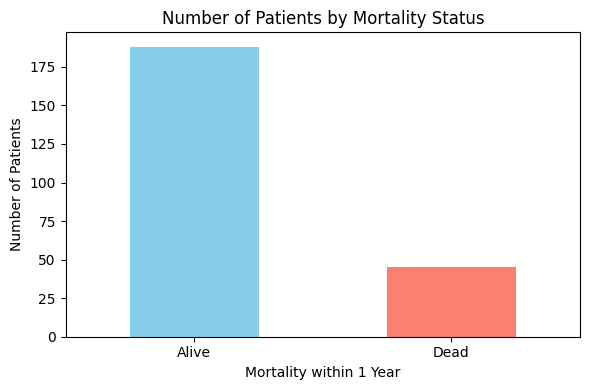

In [25]:
patient_counts = data.groupby('mortality_12m')['Patient'].nunique()

plt.figure(figsize=(6, 4))
patient_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Alive', 'Dead'], rotation=0)
plt.ylabel('Number of Patients')
plt.xlabel('Mortality within 1 Year')
plt.title('Number of Patients by Mortality Status')
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.tight_layout()
plt.show()

#### How many CTs do we have 12m data for?

In [26]:
len(data[data.mortality_12m == 1].filename.unique())

349

In [27]:
len(data[data.mortality_12m == 0].filename.unique())

1461

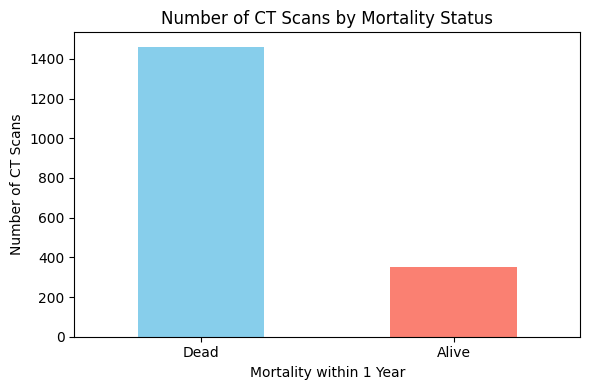

In [28]:
ct_counts = data.groupby('mortality_12m')['filename'].nunique()

plt.figure(figsize=(6, 4))
ct_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0, 1], ['Dead', 'Alive'], rotation=0)
plt.ylabel('Number of CT Scans')
plt.xlabel('Mortality within 1 Year')
plt.title('Number of CT Scans by Mortality Status')
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
data['date_of_CT'] = pd.to_datetime(data['date_of_CT'])
data['tx_date'] = pd.to_datetime(data['tx_date'])

/tmp/ipykernel_260702/3511035799.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['tx_date'] = pd.to_datetime(data['tx_date'])


In [30]:
data['days_since_transplant'] = (data['date_of_CT'] - data['tx_date']).dt.days
data['years_since_transplant'] = (data['date_of_CT'] - data['tx_date']).dt.days // 365
data['months_since_transplant'] = (data['date_of_CT'] - data['tx_date']).dt.days // 30

In [31]:
ct_counts = data.groupby('years_since_transplant').size()

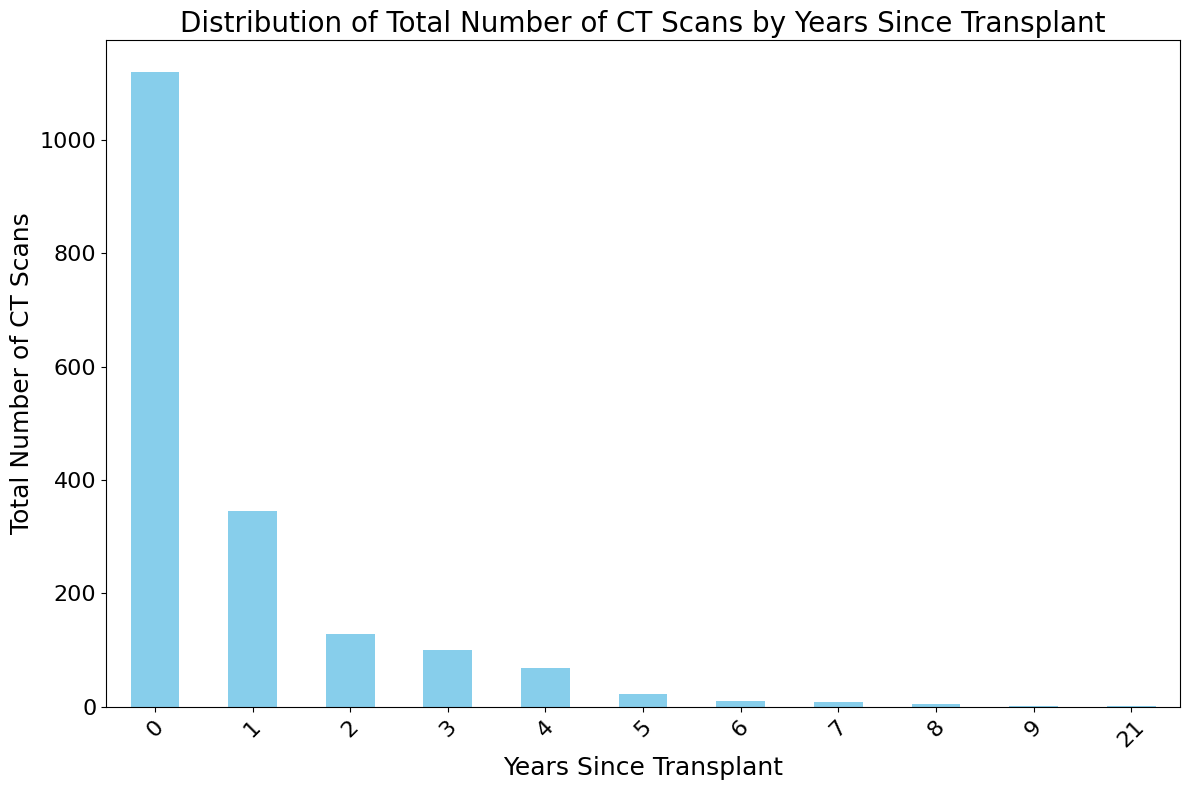

In [32]:
plt.figure(figsize=(12, 8))
ct_counts.plot(kind='bar', color='skyblue')

plt.title('Distribution of Total Number of CT Scans by Years Since Transplant', fontsize=20)
plt.xlabel('Years Since Transplant', fontsize=18)
plt.ylabel('Total Number of CT Scans', fontsize=18)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

plt.grid(axis='y', linestyle='', alpha=0.7)
plt.tight_layout()
plt.show()

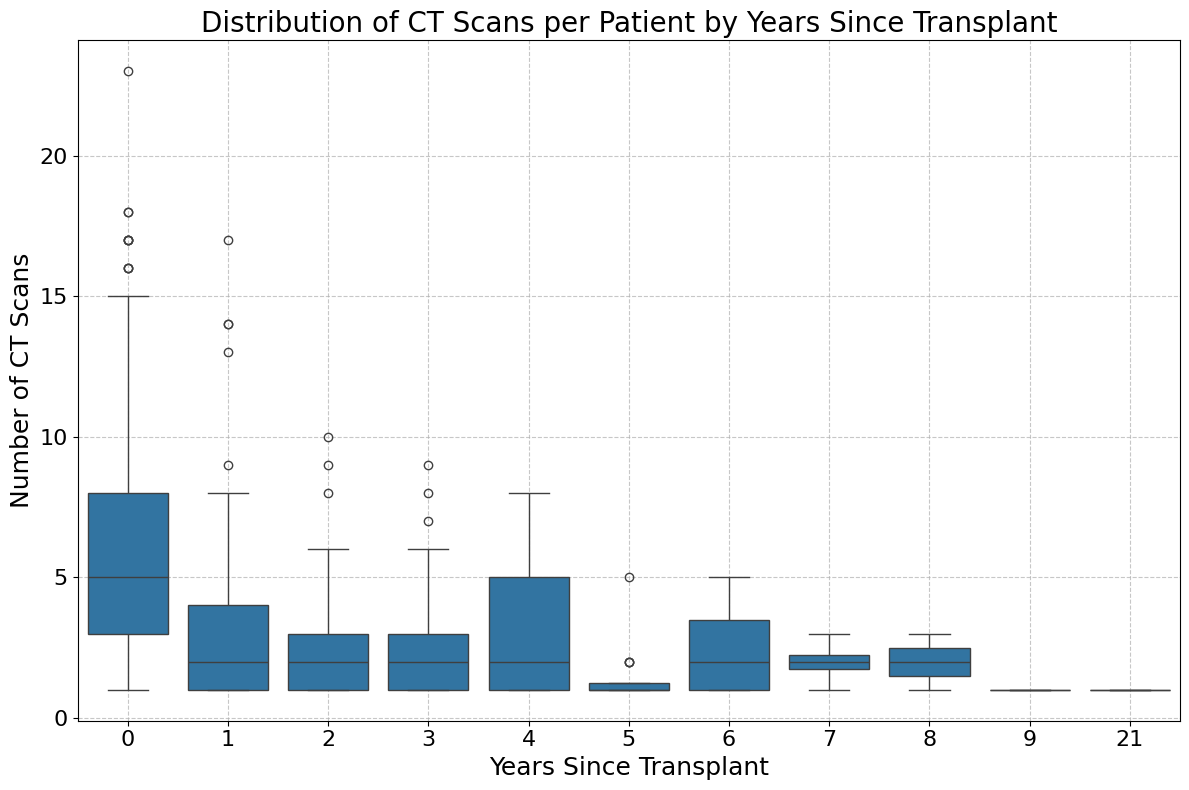

In [33]:
ct_counts = data.groupby(['Patient', 'years_since_transplant']).size().reset_index(name='CT_Count')

plt.figure(figsize=(12, 8))
sns.boxplot(x='years_since_transplant', y='CT_Count', data=ct_counts, showfliers=True)

plt.title('Distribution of CT Scans per Patient by Years Since Transplant', fontsize=20)
plt.xlabel('Years Since Transplant', fontsize=18)
plt.ylabel('Number of CT Scans', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
data.groupby('Sex')['Patient'].nunique()

Sex
Female     83
Male      117
Name: Patient, dtype: int64

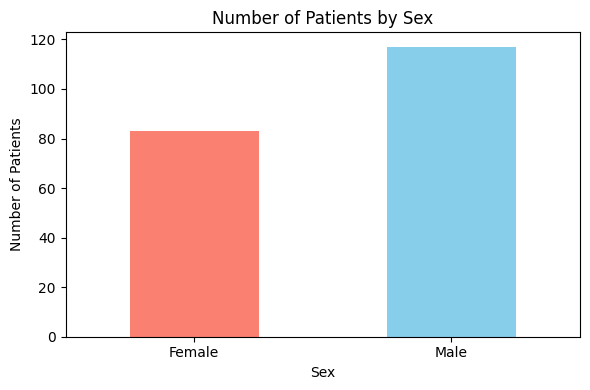

In [48]:
plt.figure(figsize=(6, 4))
data.groupby('Sex')['Patient'].nunique().plot(kind='bar', color=['salmon', 'skyblue'])
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.ylabel('Number of Patients')
plt.xlabel('Sex')
plt.title('Number of Patients by Sex')
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
data.groupby('Race')['Patient'].nunique()

Race
American Indian or Alaska Native               6
Asian                                         10
Black or African American                     17
Native Hawaiian or Other Pacific Islander      1
Unknown                                       24
White                                        143
Name: Patient, dtype: int64

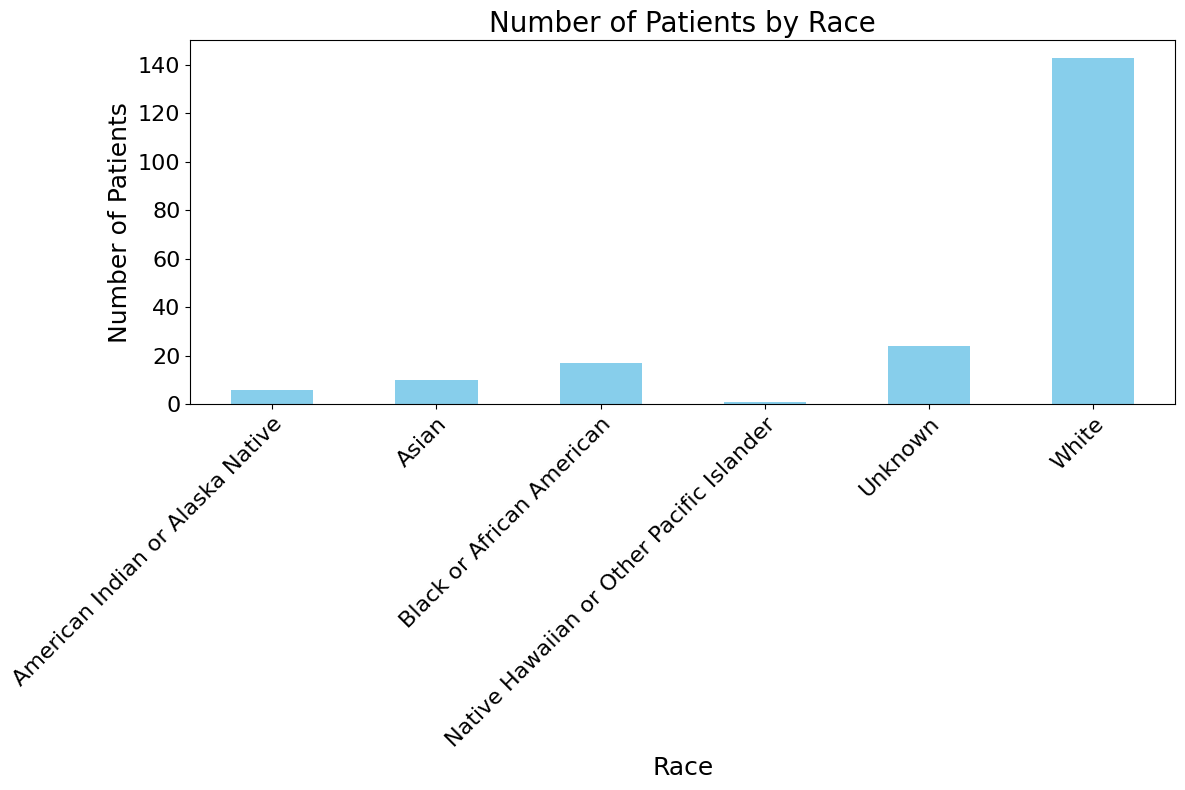

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = data.groupby('Race')['Patient'].nunique().plot(kind='bar', color='skyblue')

plt.title('Number of Patients by Race', fontsize=20)
plt.xlabel('Race', fontsize=18)
plt.ylabel('Number of Patients', fontsize=18)

# Center and adjust the x-tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', fontsize=16)

plt.yticks(fontsize=16)
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.tight_layout()
plt.show()

#### How many patients do we have 36m data for?

In [27]:
len(data[data.mortality_36m == 1].Patient.unique())

45

#### How many CTs do we have 36m data for?

In [28]:
len(data[data.mortality_36m == 1].filename.unique())

537

In [29]:
len(data[data.Mortality == "Alive"].filename.unique())

1201

In [30]:
len(data[data.mortality_12m == 0].filename.unique())

1461